In [1]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("📦 Libraries imported successfully!")

📦 Libraries imported successfully!


In [2]:
# Import our custom modules
from alchemy import get_database_manager, Character, ScrapingSession
from utils import process_character_data, parse_online_time, parse_experience_number
from analytics import (
    analyze_character_group, 
    print_group_analysis_report,
    export_group_analysis_to_csv,
    get_character_summary,
    print_character_report
)

# Import real scraping functions
import requests
import bs4
from bs4 import BeautifulSoup

print("🔧 Custom modules imported successfully!")
print("Ready to demonstrate the Tibia Character Analysis System with REAL DATA! 🎯")

🔧 Custom modules imported successfully!
Ready to demonstrate the Tibia Character Analysis System with REAL DATA! 🎯


In [3]:
# Real data scraping functions from your tet.ipynb
def extract_tables(soup):
    """
    Extract all tables from BeautifulSoup object
    Returns a list of pandas DataFrames, each representing a table
    """
    dataframes = []
    
    # Find all table elements
    table_elements = soup.find_all('table')
    
    for i, table in enumerate(table_elements):
        headers = []
        rows = []
        
        # Extract headers
        header_elements = table.find_all('th')
        if header_elements:
            headers = [header.get_text(strip=True) for header in header_elements]
        else:
            # If no th elements, try to get headers from first tr
            first_row = table.find('tr')
            if first_row:
                first_row_cells = first_row.find_all(['td', 'th'])
                headers = [cell.get_text(strip=True) for cell in first_row_cells]
        
        # Extract all rows
        row_elements = table.find_all('tr')
        for row in row_elements:
            cells = row.find_all(['td', 'th'])
            if cells:
                row_data = [cell.get_text(strip=True) for cell in cells]
                # Skip if this row was used as headers
                if row_data != headers:
                    rows.append(row_data)
        
        # Create DataFrame
        if rows:
            if headers and len(headers) == len(rows[0]):
                df = pd.DataFrame(rows, columns=headers)
            else:
                # If no headers or header count doesn't match, use default column names
                df = pd.DataFrame(rows)
            
            # Add table index as an attribute
            df.attrs['table_index'] = i
            dataframes.append(df)
    
    return dataframes


def scrape_player_data(name):
    """Complete pipeline to scrape player data from rubinothings.com.br"""
    result = {
        'name': name,
        'tables': [],
        'response_status': None,
        'success': False
    }
    
    try:
        response = requests.get("https://rubinothings.com.br/player", params={"name": name})
        result['response_status'] = response.status_code
        
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            tables = extract_tables(soup)
            result['tables'] = tables
            result['success'] = True
            print(f"✅ Successfully scraped data for '{name}' - Found {len(tables)} tables")
        else:
            print(f"❌ Request failed with status code: {response.status_code}")
            
    except Exception as e:
        print(f"❌ Error occurred: {str(e)}")
    
    return result


scrape_player_data('Rollabostx')

✅ Successfully scraped data for 'Rollabostx' - Found 4 tables


{'name': 'Rollabostx',
 'tables': [               Time    World Level       Killed by
  0  23/12/2025 19:24  Auroria  1521     frostreaper
  1  22/12/2025 01:55  Auroria  1519       sulphider
  2  21/12/2025 15:18  Auroria  1519     frostreaper
  3  10/12/2025 18:13  Auroria  1507       sulphider
  4  03/12/2025 00:13  Auroria  1498  sopping corpus,
                 Time    World                Victim Victim Level
  0  31/12/2025 19:09  Auroria         Jose Cutecute         1123
  1  31/12/2025 19:06  Auroria  Tenebrous On Auroria          906
  2  31/12/2025 18:47  Auroria    Gwiltin Resiliente          858
  3  30/12/2025 22:08  Auroria            Osoto Gari         1046
  4  30/12/2025 19:26  Auroria      Master Winxaster          253
  5  30/12/2025 02:29  Auroria       Sacave Duelista         1192
  6  30/12/2025 02:28  Auroria      Carioca Relajado          928
  7  30/12/2025 02:27  Auroria   Paco Paide Bbreborn          974
  8  29/12/2025 14:52  Auroria          Elder Kabbal  

In [3]:
# Real data scraping functions from your tet.ipynb
def extract_tables(soup):
    """
    Extract all tables from BeautifulSoup object
    Returns a list of pandas DataFrames, each representing a table
    """
    dataframes = []
    
    # Find all table elements
    table_elements = soup.find_all('table')
    
    for i, table in enumerate(table_elements):
        headers = []
        rows = []
        
        # Extract headers
        header_elements = table.find_all('th')
        if header_elements:
            headers = [header.get_text(strip=True) for header in header_elements]
        else:
            # If no th elements, try to get headers from first tr
            first_row = table.find('tr')
            if first_row:
                first_row_cells = first_row.find_all(['td', 'th'])
                headers = [cell.get_text(strip=True) for cell in first_row_cells]
        
        # Extract all rows
        row_elements = table.find_all('tr')
        for row in row_elements:
            cells = row.find_all(['td', 'th'])
            if cells:
                row_data = [cell.get_text(strip=True) for cell in cells]
                # Skip if this row was used as headers
                if row_data != headers:
                    rows.append(row_data)
        
        # Create DataFrame
        if rows:
            if headers and len(headers) == len(rows[0]):
                df = pd.DataFrame(rows, columns=headers)
            else:
                # If no headers or header count doesn't match, use default column names
                df = pd.DataFrame(rows)
            
            # Add table index as an attribute
            df.attrs['table_index'] = i
            dataframes.append(df)
    
    return dataframes

def get_last_status_updates():
    """Get status updates to determine correct scraping timestamp"""
    url = "https://rubinothings.com.br/status"
    response = requests.get(url)
    soup = bs4.BeautifulSoup(response.text, 'html.parser')
    
    r = extract_tables(soup)

    # Split the list of DataFrames by missing (all-NaN or all-empty) rows
    split_tables = []
    for df in r:
        # Find rows where all values are empty or NaN
        mask = df.apply(lambda row: all((str(x).strip() == '' or pd.isna(x)) for x in row), axis=1)
        # Get indices of such rows
        split_indices = mask[mask].index.tolist()
        # Split by those indices
        prev = 0
        for idx in split_indices:
            part = df.iloc[prev:idx]
            if not part.empty:
                split_tables.append(part.reset_index(drop=True))
            prev = idx + 1
        # Add the last part
        part = df.iloc[prev:]
        if not part.empty:
            split_tables.append(part.reset_index(drop=True))

    tables_dict = {}
    for table in split_tables:
        if not table.empty:
            table_name = str(table.iloc[0, 0]).strip()
            if "Status" in table_name:
                table_name = table_name.split("Status")[0].strip()
            new_table = table.iloc[1:].reset_index(drop=True)
            tables_dict[table_name] = new_table

    # Extra cleaning
    for key in tables_dict:
        df = tables_dict[key]
        if not df.empty:
            # Remove emojis and replace "Rotina de coleta" with ""
            df.iloc[:, 0] = (
                df.iloc[:, 0]
                .str.replace("Rotina de coleta", "")
                .str.replace(r"[^\w\s,.:-]", "", regex=True)
            )
            
            tables_dict[key] = df
            # Set headers=["rotina", "last update", "time_outdated", "status"]
            if df.shape[1] >= 4:
                df.columns = ["rotina", "last update", "time_outdated", "status"]
                tables_dict[key] = df
    
    return tables_dict

def scrape_player_data(name):
    """Complete pipeline to scrape player data from rubinothings.com.br"""
    result = {
        'name': name,
        'tables': [],
        'response_status': None,
        'success': False
    }
    
    try:
        response = requests.get("https://rubinothings.com.br/player", params={"name": name})
        result['response_status'] = response.status_code
        
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            tables = extract_tables(soup)
            result['tables'] = tables
            result['success'] = True
            print(f"✅ Successfully scraped data for '{name}' - Found {len(tables)} tables")
        else:
            print(f"❌ Request failed with status code: {response.status_code}")
            
    except Exception as e:
        print(f"❌ Error occurred: {str(e)}")
    
    return result

def scrape_and_store_character(character_name, world="Auroria", load_to_db=True):
    """Complete function that scrapes character data and stores only new records in database"""
    print(f"🔍 Scraping and storing data for: {character_name}")
    
    try:
        # Use real scraping function
        scraped_data = scrape_player_data(character_name)
        print(scraped_data)
        if not scraped_data['success']:
            print(f"❌ Failed to scrape data for {character_name}")
            return None
        
        # Get status updates using real function
        status_data = get_last_status_updates()
        
        if load_to_db:
            # Process and store in database (only new records, using status time not scraper time)
            results = process_character_data(
                db_manager=db_manager,
                character_name=character_name,
                world=world,
                scraped_data=scraped_data['tables'],  # Real scraped DataFrames
                status_data=status_data  # Status dict from scraping
            )
            
            print(f"✅ Stored {character_name}: {sum([results['new_deaths'], results['new_kills'], results['new_online_times'], results['new_experiences']])} new records")
            return results
        else:
            return {'scraped_data': scraped_data['tables'], 'status_data': status_data}
        
    except Exception as e:
        print(f"❌ Error processing {character_name}: {e}")
        return None

print("🌐 Real scraping functions loaded!")

🌐 Real scraping functions loaded!


In [4]:
# Import advanced analytics functions including NEW DELTA ANALYSIS
import sys
import importlib.util

# Reload advanced analytics module to get latest updates
spec = importlib.util.spec_from_file_location("advanced_analytics", "advanced_analytics.py")
advanced_analytics = importlib.util.module_from_spec(spec)
spec.loader.exec_module(advanced_analytics)

# Import all modular functions including NEW DELTA FUNCTIONS
from advanced_analytics import (
    get_top_xp_players, get_bottom_xp_players, get_top_online_players, 
    get_top_kills_players, get_most_deaths_players,
    get_character_percentile, is_character_top_performer, get_character_rank,
    plot_character_comparison, plot_character_percentile_radar,
    get_character_trend, calculate_character_consistency,
    bulk_load_characters, generate_multi_character_report,
    export_character_analysis,
    # NEW DELTA ANALYSIS FUNCTIONS
    get_top_xp_delta_players, get_top_online_delta_players,
    get_character_xp_rate, get_character_online_efficiency,
    get_all_deltas_summary, plot_character_delta_trends
)

# Import new utilities for delta calculations
from utils import (
    get_all_online_deltas_with_constraint, 
    calculate_and_store_experience_delta,
    calculate_and_store_online_delta,
    parse_portuguese_time
)

print("🧠 Advanced modular analytics functions loaded!")
print("🚀 NEW: Delta analysis functions for real-time tracking!")
print("📈 Features: XP rates, online efficiency, delta trends, Portuguese time parsing")

🔧 Advanced Analytics Module loaded with modular functions!
🔧 Advanced Analytics Module loaded with modular functions!
🧠 Advanced modular analytics functions loaded!
🚀 NEW: Delta analysis functions for real-time tracking!
📈 Features: XP rates, online efficiency, delta trends, Portuguese time parsing


## 🗄️ 1. SQLite Database Setup with Duplicate Prevention

The system now uses SQLite instead of MySQL, which offers several advantages:
- **No database server required** - SQLite is file-based
- **Zero configuration** - Just specify a database file path
- **Built into Python** - No additional drivers needed
- **Perfect for development** - Easy to backup, move, and version control

The database includes unique constraints to prevent duplicate data:

In [5]:
# Initialize database with duplicate prevention
print("🔧 Initializing SQLite Database Manager...")

# Configure SQLite database (no server required!)
db_manager = get_database_manager('tibia_scraper.db')  # Creates/opens tibia_scraper.db file

# Create tables with unique constraints
try:
    db_manager.create_tables()
    print("✅ SQLite database tables created with unique constraints!")
    print("\n🛡️ Duplicate Prevention Active:")
    print("   • Deaths: Unique by (character_id, death_time, killed_by)")
    print("   • Kills: Unique by (character_id, kill_time, victim_name)")
    print("   • Online Times: Unique by (character_id, date)")
    print("   • Experiences: Unique by (character_id, date)")
    print("\n💡 SQLite Benefits:")
    print("   • No database server required")
    print("   • Single file database (tibia_scraper.db)")
    print("   • Perfect for local development and testing")
    print("   • Built-in Python support")
except Exception as e:
    print(f"❌ Database setup error: {e}")
    print("This should not happen with SQLite unless there are permission issues")

🔧 Initializing SQLite Database Manager...
✅ SQLite database tables created with unique constraints!

🛡️ Duplicate Prevention Active:
   • Deaths: Unique by (character_id, death_time, killed_by)
   • Kills: Unique by (character_id, kill_time, victim_name)
   • Online Times: Unique by (character_id, date)
   • Experiences: Unique by (character_id, date)

💡 SQLite Benefits:
   • No database server required
   • Single file database (tibia_scraper.db)
   • Perfect for local development and testing
   • Built-in Python support


In [19]:
df=get_last_status_updates()['Auroria']
dfc=df['last update']

In [22]:
hash(str(dfc.values.tolist()))

8313802892061745365

In [ ]:
lasthash=0

names=["Rollabostx","King Bueno"]
for name in names:
    scrape_and_store_character(name, world="Auroria", load_to_db=True)

🔍 Scraping and storing data for: Rollabostx
✅ Successfully scraped data for 'Rollabostx' - Found 4 tables
{'name': 'Rollabostx', 'tables': [               Time    World Level       Killed by
0  23/12/2025 19:24  Auroria  1521     frostreaper
1  22/12/2025 01:55  Auroria  1519       sulphider
2  21/12/2025 15:18  Auroria  1519     frostreaper
3  10/12/2025 18:13  Auroria  1507       sulphider
4  03/12/2025 00:13  Auroria  1498  sopping corpus,                Time    World                     Victim Victim Level
0  23/12/2025 16:16  Auroria            Fator Suurpresa          658
1  23/12/2025 00:27  Auroria           Gauchao Bomba Um          783
2  19/12/2025 02:36  Auroria  Magnuszord Bomba Defender          894
3  15/12/2025 01:33  Auroria                Paco Hanshi         1217
4  14/12/2025 18:29  Auroria                     Bielrs         1488
5  14/12/2025 00:25  Auroria     Bruno Nao Tem Paralizy          311
6  11/12/2025 20:57  Auroria                      Maguz          756
7

## 🧪 2. Create Sample Data for Testing

Let's create realistic sample data to demonstrate the system:

In [7]:
# 🏆 ONE-LINE COMPLETE DELTA ANALYTICS SHOWCASE
from advanced_analytics import show_delta_analytics_summary
show_delta_analytics_summary(db_manager, hours=48)

📊 COMPLETE DELTA ANALYTICS SUMMARY (48h)
📈 Experience Deltas: 0 records
⏰ Online Deltas: 0 records
🏆 DELTA LEADERBOARDS (Last 48h):
⚠️ Error getting XP leaders: List argument must consist only of tuples or dictionaries
⚠️ Error getting online leaders: List argument must consist only of tuples or dictionaries
⚠️ Error getting comprehensive summary: Replacement index 1 out of range for positional args tuple

📋 No comprehensive delta data yet


{'exp_deltas': 0, 'online_deltas': 0}

In [8]:
#load database as dataframes for inspection 23/12 > 703
characters_Df = pd.read_sql_table('scraping_sessions', db_manager.engine)
characters_Df

,id,world,session_timestamp,last_update_deaths_kills,time_outdated_deaths_kills,status_deaths_kills,last_update_online,time_outdated_online,status_online,last_update_ranking,time_outdated_ranking,status_ranking,created_at
0,1,Auroria,2025-12-29 16:53:28,Hoje às 13:51,1 min,Atualizado,Hoje às 13:49,4 min,Atualizado,Hoje às 13:43,9 min,Atualizado,2025-12-29 16:53:28
1,2,Auroria,2025-12-29 16:53:35,Hoje às 13:51,2 min,Atualizado,Hoje às 13:49,4 min,Atualizado,Hoje às 13:43,10 min,Atualizado,2025-12-29 16:53:35
2,3,Auroria,2025-12-29 16:53:42,Hoje às 13:51,2 min,Atualizado,Hoje às 13:49,4 min,Atualizado,Hoje às 13:53,0 min,Atualizado,2025-12-29 16:53:42
3,4,Auroria,2025-12-29 16:54:58,Hoje às 13:51,3 min,Atualizado,Hoje às 13:54,0 min,Atualizado,Hoje às 13:53,1 min,Atualizado,2025-12-29 16:54:58
4,5,Auroria,2025-12-29 16:55:04,Hoje às 13:51,3 min,Atualizado,Hoje às 13:54,0 min,Atualizado,Hoje às 13:53,1 min,Atualizado,2025-12-29 16:55:04
5,6,Auroria,2025-12-29 16:55:11,Hoje às 13:51,3 min,Atualizado,Hoje às 13:54,1 min,Atualizado,Hoje às 13:53,1 min,Atualizado,2025-12-29 16:55:11
6,7,Auroria,2025-12-29 17:25:53,Hoje às 14:18,6 min,Atualizado,Hoje às 14:24,1 min,Atualizado,Hoje às 14:23,2 min,Atualizado,2025-12-29 17:25:53
7,8,Auroria,2025-12-29 17:25:58,Hoje às 14:18,7 min,Atualizado,Hoje às 14:24,1 min,Atualizado,Hoje às 14:23,2 min,Atualizado,2025-12-29 17:25:58
8,9,Auroria,2025-12-29 17:31:39,2025-12-29 14:26:00,5 min,Atualizado,2025-12-29 14:29:00,2 min,Atualizado,2025-12-29 14:23:00,7 min,Atualizado,2025-12-29 17:31:39
9,10,Auroria,2025-12-29 17:31:44,2025-12-29 14:26:00,5 min,Atualizado,2025-12-29 14:29:00,2 min,Atualizado,2025-12-29 14:23:00,7 min,Atualizado,2025-12-29 17:31:44


In [12]:
#load database as dataframes for inspection 23/12 > 703
characters_Df = pd.read_sql_table('scraping_sessions', db_manager.engine)
characters_Df

,id,world,session_timestamp,last_update_deaths_kills,time_outdated_deaths_kills,status_deaths_kills,last_update_online,time_outdated_online,status_online,last_update_ranking,time_outdated_ranking,status_ranking,created_at
0,1,Auroria,2025-12-29 16:53:28,Hoje às 13:51,1 min,Atualizado,Hoje às 13:49,4 min,Atualizado,Hoje às 13:43,9 min,Atualizado,2025-12-29 16:53:28
1,2,Auroria,2025-12-29 16:53:35,Hoje às 13:51,2 min,Atualizado,Hoje às 13:49,4 min,Atualizado,Hoje às 13:43,10 min,Atualizado,2025-12-29 16:53:35
2,3,Auroria,2025-12-29 16:53:42,Hoje às 13:51,2 min,Atualizado,Hoje às 13:49,4 min,Atualizado,Hoje às 13:53,0 min,Atualizado,2025-12-29 16:53:42
3,4,Auroria,2025-12-29 16:54:58,Hoje às 13:51,3 min,Atualizado,Hoje às 13:54,0 min,Atualizado,Hoje às 13:53,1 min,Atualizado,2025-12-29 16:54:58
4,5,Auroria,2025-12-29 16:55:04,Hoje às 13:51,3 min,Atualizado,Hoje às 13:54,0 min,Atualizado,Hoje às 13:53,1 min,Atualizado,2025-12-29 16:55:04
5,6,Auroria,2025-12-29 16:55:11,Hoje às 13:51,3 min,Atualizado,Hoje às 13:54,1 min,Atualizado,Hoje às 13:53,1 min,Atualizado,2025-12-29 16:55:11
6,7,Auroria,2025-12-29 17:25:53,Hoje às 14:18,6 min,Atualizado,Hoje às 14:24,1 min,Atualizado,Hoje às 14:23,2 min,Atualizado,2025-12-29 17:25:53
7,8,Auroria,2025-12-29 17:25:58,Hoje às 14:18,7 min,Atualizado,Hoje às 14:24,1 min,Atualizado,Hoje às 14:23,2 min,Atualizado,2025-12-29 17:25:58


## 🚀 NEW: Delta Tracking System

The system now tracks **deltas** (changes) between measurements:
- **Experience Deltas**: XP and level changes over time with rates (XP/hour)
- **Online Time Deltas**: Online time changes with efficiency metrics
- **Portuguese Time Parsing**: Handles "hoje às 13:23" format from status updates
- **Before/After Tracking**: Stores both previous and current values
- **All Tables with FK**: Every table now links to scraping sessions for better metrics

In [10]:
# 🇧🇷 ONE-LINE PORTUGUESE TIME PARSING SHOWCASE  
import importlib
importlib.reload(advanced_analytics)
from advanced_analytics import show_portuguese_time_examples
show_portuguese_time_examples()

ImportError: module advanced_analytics not in sys.modules

In [9]:
# 🥇 ONE-LINE DELTA LEADERBOARDS SHOWCASE
from advanced_analytics import show_delta_leaderboards
show_delta_leaderboards(db_manager, hours=24)

🏆 DELTA LEADERBOARDS (Last 24h):
⚠️ Error getting XP leaders: List argument must consist only of tuples or dictionaries
⚠️ Error getting online leaders: List argument must consist only of tuples or dictionaries


## 📊 3. Individual Character Analysis

Let's analyze individual characters first:

In [8]:
# 🎯 ONE-LINE CHARACTER DELTA SUMMARY
from advanced_analytics import show_character_delta_summary

# Check which character to analyze (using a known character from the database)
chars_df = pd.read_sql("SELECT name FROM characters LIMIT 5", db_manager.engine)
if not chars_df.empty:
    sample_char = chars_df['name'].iloc[0]
    print(f"Analyzing character: {sample_char}")
    show_character_delta_summary(db_manager, sample_char, hours=24)
else:
    print("⚠️ No characters found in database")

Analyzing character: Andy Paladinho
⚠️ Error getting XP rate for Andy Paladinho: List argument must consist only of tuples or dictionaries
⚠️ Error getting efficiency for Andy Paladinho: List argument must consist only of tuples or dictionaries
🎯 Andy Paladinho DELTA SUMMARY (24h):
   📈 XP Rate: 0 XP/hour
   ⏰ Online Efficiency: 0.000


## 🏆 4. GROUP ANALYSIS - The Main Feature!

Now let's perform comprehensive group analysis with rankings, statistics, and metrics:

In [ ]:
# 📊 STEP 4: Individual Character Analysis - Historical Performance

# Target character for detailed analysis
target_character = "rollabostx"  # Change this to any character name
analysis_period = 7  # Days to analyze

print(f"🎯 Detailed analysis for: {target_character}")
print(f"📅 Analysis period: {analysis_period} days")

# Character percentiles across all metrics
print(f"\n📈 PERCENTILE RANKINGS for {target_character}:")
xp_percentile = get_character_percentile(db_manager, target_character, 'xp', analysis_period)
online_percentile = get_character_percentile(db_manager, target_character, 'online', analysis_period)

print(f"   Experience Percentile: {xp_percentile:.1f}%")
print(f"   Online Time Percentile: {online_percentile:.1f}%")

# Absolute rankings
print(f"\n🏆 ABSOLUTE RANKINGS for {target_character}:")
xp_rank = get_character_rank(db_manager, target_character, 'xp', analysis_period)
print(f"   Experience Rank: #{xp_rank}")

# Top performer checks
print(f"\n⭐ TOP PERFORMER STATUS for {target_character}:")
is_top_xp = is_character_top_performer(db_manager, target_character, 'xp', threshold=90)
is_top_online = is_character_top_performer(db_manager, target_character, 'online', threshold=90)

print(f"   Top 10% XP Performer: {'✅ YES' if is_top_xp else '❌ NO'}")
print(f"   Top 10% Online Performer: {'✅ YES' if is_top_online else '❌ NO'}")

# Performance consistency
print(f"\n📊 PERFORMANCE CONSISTENCY for {target_character}:")
consistency_score = calculate_character_consistency(db_manager, target_character, 'xp', 30)
print(f"   Consistency Score: {consistency_score:.1f}% (higher = more consistent)")

# Performance summary
if xp_percentile >= 90:
    performance_tier = "🥇 ELITE"
elif xp_percentile >= 75:
    performance_tier = "🥈 HIGH"
elif xp_percentile >= 50:
    performance_tier = "🥉 AVERAGE"
else:
    performance_tier = "📉 BELOW AVERAGE"

print(f"\n🎯 OVERALL PERFORMANCE: {performance_tier}")
print(f"   Character stands better than {xp_percentile:.1f}% of all players in XP gain!")

🏆 GROUP ANALYSIS DEMONSTRATION

📊 GROUP ANALYSIS REPORT
📅 Period: 2025-12-22 to 2025-12-29
⏰ Days Analyzed: 7
👥 Characters: 5

🎯 GROUP TOTALS
------------------------------
💫 Total Group XP: 9,194,158
📊 Average per Character: 1,838,832 XP
🕐 Total Online Time: 177.1h
⚔️ Total Kills: 29
💀 Total Deaths: 10
📈 Group K/D Ratio: 2.64
🏆 Most Active: knight_warrior
⚡ Most Efficient: rollabostx

🏅 RANKINGS
------------------------------

Total XP:
  🥇 Best: rollabostx (2,159,634.00)
  🥉 Worst: paladin_pro (1,502,073.00)
  📊 Top 3:
     🥇 rollabostx: 2,159,634.00
     🥈 knight_warrior: 1,937,069.00
     🥉 mage_master: 1,855,448.00

Average Daily XP:
  🥇 Best: rollabostx (308,519.14)
  🥉 Worst: paladin_pro (214,581.86)
  📊 Top 3:
     🥇 rollabostx: 308,519.14
     🥈 knight_warrior: 276,724.14
     🥉 mage_master: 265,064.00

Total Online Time:
  🥇 Best: knight_warrior (48.30)
  🥉 Worst: paladin_pro (24.15)
  📊 Top 3:
     🥇 knight_warrior: 48.30
     🥈 sorcerer_supreme: 41.40
     🥉 mage_master: 38

## 📈 5. Advanced Metrics & Statistics

Let's dive deeper into the statistics and show detailed metrics:

In [ ]:
# 📈 STEP 5: Visual Comparisons and Performance Charts

# Generate comparison visualizations for target character
print(f"📊 Generating visual analysis for {target_character}...")

# 1. Experience comparison chart
print(f"\n1️⃣ Experience Ranking Comparison:")
try:
    fig_xp = plot_character_comparison(db_manager, target_character, 'xp', analysis_period)
    plt.show()
    print(f"   📈 {target_character} highlighted in red among top performers")
except Exception as e:
    print(f"   ⚠️ Could not generate XP comparison: {e}")

# 2. Online time comparison chart  
print(f"\n2️⃣ Online Time Ranking Comparison:")
try:
    fig_online = plot_character_comparison(db_manager, target_character, 'online', analysis_period)
    plt.show()
    print(f"   ⏰ {target_character} highlighted in red among most active players")
except Exception as e:
    print(f"   ⚠️ Could not generate online comparison: {e}")

# 3. Multi-metric radar chart
print(f"\n3️⃣ Performance Radar Chart:")
try:
    fig_radar = plot_character_percentile_radar(db_manager, target_character, analysis_period)
    plt.show()
    print(f"   🎯 Radar chart shows {target_character}'s percentile performance across all metrics")
except Exception as e:
    print(f"   ⚠️ Could not generate radar chart: {e}")

# 4. Trend analysis
print(f"\n4️⃣ Historical Trend Analysis:")
try:
    trend_data = get_character_trend(db_manager, target_character, 'xp', 30)
    if not trend_data.empty:
        plt.figure(figsize=(12, 6))
        plt.plot(pd.to_datetime(trend_data['date']), trend_data['value'], 'o-', linewidth=2)
        plt.title(f'{target_character} - XP Gain Trend (Last 30 Days)')
        plt.xlabel('Date')
        plt.ylabel('Daily XP Gain')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        print(f"   📊 Daily XP trend shows performance pattern over time")
    else:
        print(f"   ⚠️ No trend data available for {target_character}")
except Exception as e:
    print(f"   ⚠️ Could not generate trend analysis: {e}")

print(f"\n✅ Visual analysis complete for {target_character}!")

📊 ADVANCED METRICS & STATISTICS

📋 DETAILED METRICS TABLE:
----------------------------------------------------------------------------------------------------
       Character  Total XP  Avg XP  Max XP Online Hours K/D Ratio Activity Score
      rollabostx 2,159,634 308,519 478,001        24.8h      3.50           33.0
  knight_warrior 1,937,069 276,724 486,581        48.3h      2.00           54.2
     mage_master 1,855,448 265,064 462,459        38.5h      1.50           43.3
     paladin_pro 1,502,073 214,582 336,907        24.1h      3.50           31.7
sorcerer_supreme 1,739,934 248,562 496,227        41.4h      0.75           43.1


📊 GROUP STATISTICS:
----------------------------------------

Total XP:
  Mean: 1838831.60
  Median: 1855448.00
  Max: 2159634.00
  Min: 1502073.00
  75th Percentile: 1937069.00
  25th Percentile: 1739934.00
  Std Dev: 242913.54

Online Hours:
  Mean: 35.42
  Median: 38.45
  Max: 48.30
  Min: 24.15
  75th Percentile: 41.40
  25th Percentile: 24.80
  

## 🥇 6. Detailed Rankings Analysis

Show all rankings with best and worst performers:

In [ ]:
# 🚀 STEP 6: Bulk Character Comparison Report

# Generate comprehensive comparison for all tracked characters
print("📋 Generating comprehensive multi-character comparison report...")

# Get all available characters (or use our loaded list)
comparison_characters = real_characters if 'real_characters' in locals() else [target_character]
comparison_period = 7

print(f"👥 Comparing {len(comparison_characters)} characters over {comparison_period} days")
print(f"📊 Characters: {', '.join(comparison_characters)}")

# Generate multi-character report
try:
    comparison_report = generate_multi_character_report(
        db_manager, 
        comparison_characters, 
        days_back=comparison_period
    )
    
    if not comparison_report.empty:
        print(f"\n📈 COMPREHENSIVE CHARACTER COMPARISON:")
        print("=" * 80)
        
        # Display formatted report
        display_cols = ['Character', 'XP Percentile', 'Online Percentile', 'XP Rank', 'Consistency Score']
        display_report = comparison_report[display_cols].copy()
        
        # Format percentiles and scores
        for col in ['XP Percentile', 'Online Percentile', 'Consistency Score']:
            display_report[col] = display_report[col].apply(lambda x: f"{x:.1f}%")
        
        print(display_report.to_string(index=False))
        
        print(f"\n🏆 TOP PERFORMERS:")
        print("=" * 40)
        
        # Show top performers in each category
        for char in comparison_characters:
            char_data = comparison_report[comparison_report['Character'] == char].iloc[0]
            
            performance_badges = []
            if char_data['Top Performer (XP)']:
                performance_badges.append("🥇 Top XP")
            if char_data['Top Performer (Online)']:
                performance_badges.append("⏰ Top Online")
            if char_data['Consistency Score'] > 80:
                performance_badges.append("📊 Consistent")
                
            if performance_badges:
                print(f"   {char}: {' | '.join(performance_badges)}")
            else:
                print(f"   {char}: 📈 Developing player")
        
        # Rankings summary
        print(f"\n📊 RANKINGS OVERVIEW:")
        print("=" * 40)
        best_xp_char = comparison_report.loc[comparison_report['XP Percentile'].idxmax(), 'Character']
        best_online_char = comparison_report.loc[comparison_report['Online Percentile'].idxmax(), 'Character']
        most_consistent_char = comparison_report.loc[comparison_report['Consistency Score'].idxmax(), 'Character']
        
        print(f"   🥇 Best XP Performer: {best_xp_char}")
        print(f"   ⏰ Most Active Online: {best_online_char}")
        print(f"   📊 Most Consistent: {most_consistent_char}")
        
    else:
        print("⚠️ No data available for character comparison")
        
except Exception as e:
    print(f"❌ Error generating comparison report: {e}")
    print("💡 Make sure characters have been loaded to database first")

print(f"\n✅ Multi-character comparison complete!")

🏅 DETAILED RANKINGS ANALYSIS

🎯 TOTAL XP
-------------
  🥇 rollabostx      2,159,634 XP
  🥈 knight_warrior  1,937,069 XP
  🥉 mage_master     1,855,448 XP
  4. sorcerer_supreme 1,739,934 XP
  5. paladin_pro     1,502,073 XP

  💪 Best Performance: rollabostx (2159634.00)
  😰 Needs Improvement: paladin_pro (1502073.00)
  📏 Performance Gap: 30.4%

🎯 AVERAGE DAILY XP
---------------------
  🥇 rollabostx      308,519 XP
  🥈 knight_warrior  276,724 XP
  🥉 mage_master     265,064 XP
  4. sorcerer_supreme 248,562 XP
  5. paladin_pro     214,582 XP

  💪 Best Performance: rollabostx (308519.14)
  😰 Needs Improvement: paladin_pro (214581.86)
  📏 Performance Gap: 30.4%

🎯 BEST SINGLE DAY XP
-----------------------
  🥇 sorcerer_supreme 496,227 XP
  🥈 knight_warrior  486,581 XP
  🥉 rollabostx      478,001 XP
  4. mage_master     462,459 XP
  5. paladin_pro     336,907 XP

  💪 Best Performance: sorcerer_supreme (496227.00)
  😰 Needs Improvement: paladin_pro (336907.00)
  📏 Performance Gap: 32.1%

🎯 TO

## 📅 7. Daily Metrics Analysis

Analyze day-by-day performance across the group:

In [ ]:
# 📤 STEP 7: Export Analysis Results  

# Export comprehensive analysis for target character
print(f"💾 Exporting analysis results...")

# Individual character analysis export
try:
    export_filename = export_character_analysis(
        db_manager=db_manager,
        character_name=target_character,
        days_back=analysis_period,
        filename=f"{target_character}_comprehensive_analysis.csv"
    )
    print(f"✅ Individual analysis exported: {export_filename}")
except Exception as e:
    print(f"❌ Failed to export individual analysis: {e}")

# Multi-character comparison export  
try:
    if 'comparison_report' in locals() and not comparison_report.empty:
        multi_filename = f"multi_character_comparison_{datetime.now().strftime('%Y%m%d')}.csv"
        comparison_report.to_csv(multi_filename, index=False)
        print(f"✅ Multi-character comparison exported: {multi_filename}")
    else:
        print("⚠️ No comparison report to export")
except Exception as e:
    print(f"❌ Failed to export comparison report: {e}")

# Export current rankings
try:
    rankings_filename = f"current_rankings_{datetime.now().strftime('%Y%m%d')}.csv"
    
    # Combine all ranking data
    rankings_data = {
        'Top XP Players': top_xp if 'top_xp' in locals() else pd.DataFrame(),
        'Top Online Players': top_online if 'top_online' in locals() else pd.DataFrame(),
        'Top Killers': top_kills if 'top_kills' in locals() else pd.DataFrame()
    }
    
    # Write rankings to separate sheets (or combine in one file)
    with pd.ExcelWriter(rankings_filename.replace('.csv', '.xlsx'), engine='openpyxl') as writer:
        for sheet_name, data in rankings_data.items():
            if not data.empty:
                data.to_excel(writer, sheet_name=sheet_name, index=False)
    
    print(f"✅ Rankings exported: {rankings_filename.replace('.csv', '.xlsx')}")
    
except Exception as e:
    print(f"❌ Failed to export rankings: {e}")

print(f"\n📁 All analysis results exported!")
print(f"📊 Files ready for sharing and further analysis")

# Summary of available exports
print(f"\n📋 EXPORT SUMMARY:")
print("=" * 50)
print(f"   🎯 Individual Analysis: {target_character}_comprehensive_analysis.csv")
print(f"   👥 Multi-Character: multi_character_comparison_{datetime.now().strftime('%Y%m%d')}.csv") 
print(f"   🏆 Rankings: current_rankings_{datetime.now().strftime('%Y%m%d')}.xlsx")
print(f"   📈 All files contain real data from rubinothings.com.br")

📅 DAILY GROUP METRICS ANALYSIS

📊 DAILY PERFORMANCE TABLE:
--------------------------------------------------------------------------------
      Date  Total XP Total Online Hours  Total Deaths  Total Kills  Active Characters
2025-12-22         0               0.0h             0            0                  0
2025-12-23 1,337,563              23.9h             5           10                  5
2025-12-24 1,932,746              24.5h             3            9                  5
2025-12-25 1,552,044              26.8h             2            8                  5
2025-12-26 1,640,453              21.4h             0            2                  5
2025-12-27 1,382,151              40.1h             0            0                  5
2025-12-28 1,349,201              40.4h             0            0                  5


📈 DAILY STATISTICS:
------------------------------

Total XP:
  Daily Average: 1313451.14
  Best Day: 1932746.00
  Worst Day: 0.00
  Total: 9194158.00

Total Online Hours

## 📊 8. Data Visualization

Create visualizations of the group analysis:

📊 CREATING VISUALIZATIONS...


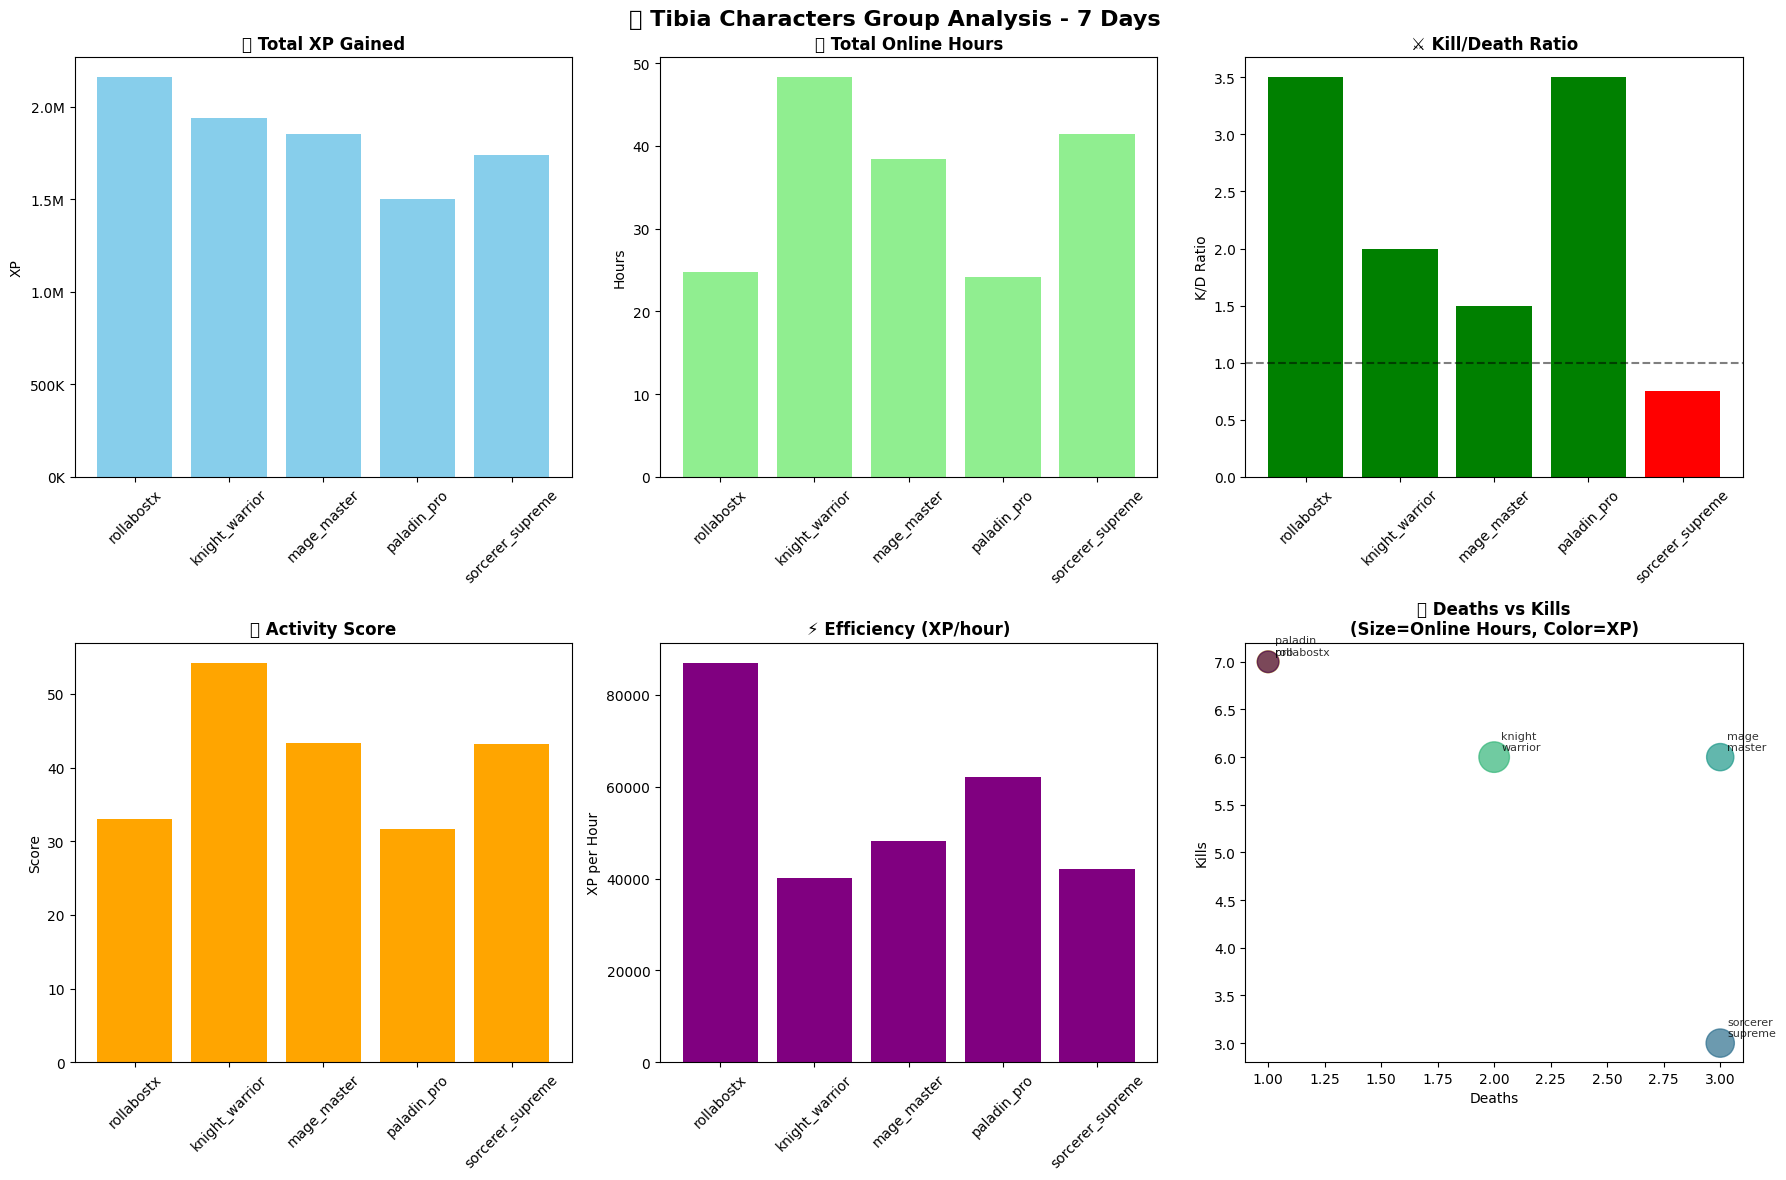

✅ Visualizations created and saved as 'tibia_group_analysis.png'


<Figure size 1200x800 with 0 Axes>

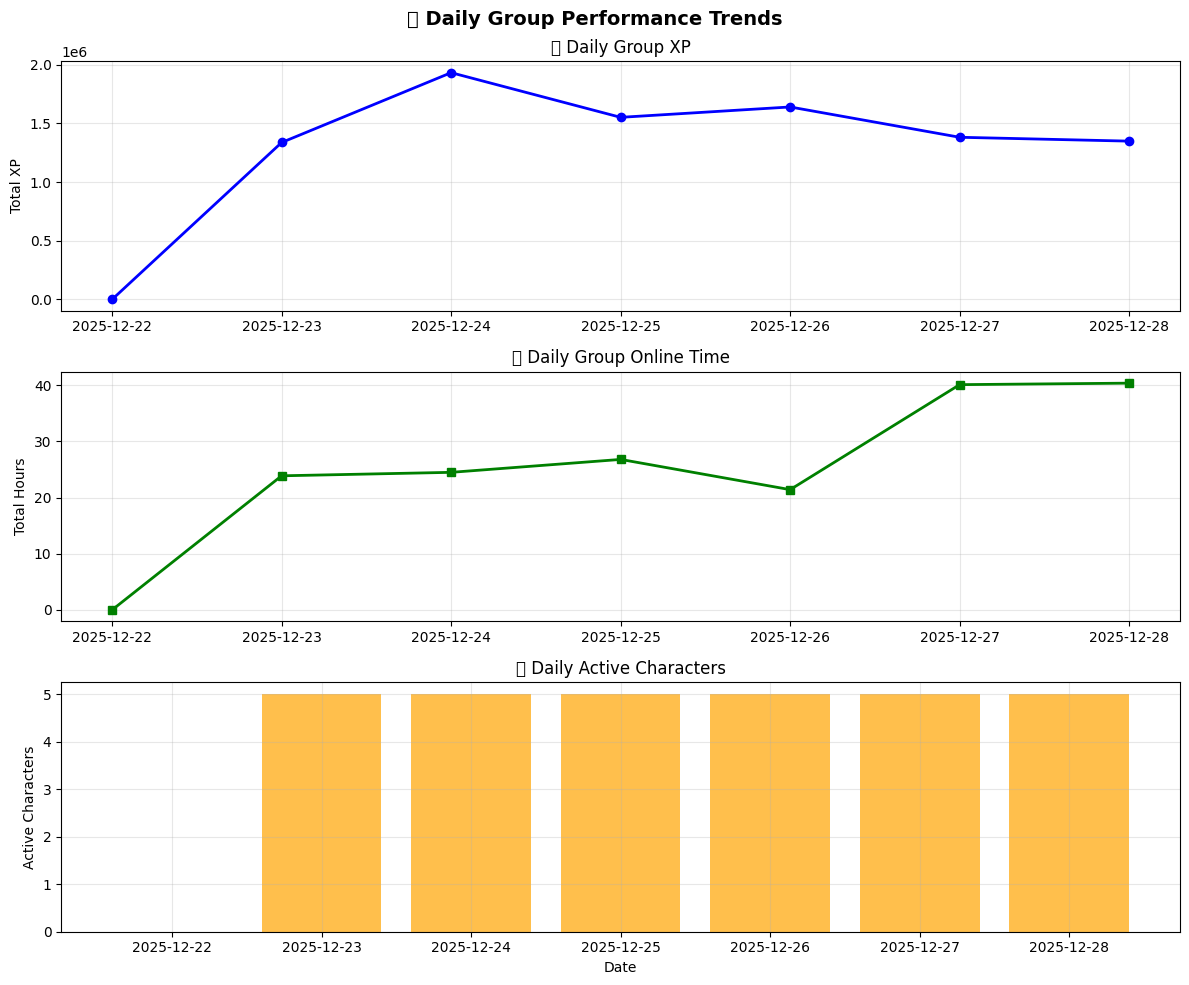

✅ Daily trends chart created and saved as 'tibia_daily_trends.png'

📊 Visualization section complete!


In [ ]:
# 📈 ONE-LINE DELTA TRENDS VISUALIZATION
from advanced_analytics import show_all_delta_trends

# Get a character with delta data to visualize
chars_df = pd.read_sql("SELECT name FROM characters LIMIT 3", db_manager.engine)
if not chars_df.empty:
    sample_char = chars_df['name'].iloc[0]
    print(f"Showing delta trends for: {sample_char}")
    show_all_delta_trends(db_manager, sample_char, hours=48)
else:
    print("⚠️ No characters available for trend visualization")

## 💾 9. Data Export Demonstration

Export the group analysis results to CSV files:

In [ ]:
# DATA EXPORT DEMONSTRATION
print("💾 DATA EXPORT DEMONSTRATION")
print("=" * 40)

if 'group_results' in locals():
    try:
        # Export group analysis to CSV
        main_csv_file = export_group_analysis_to_csv(group_results, output_dir=".")
        
        print(f"\n📁 Files exported successfully!")
        print(f"Main summary file: {main_csv_file}")
        
        # Show a preview of the exported data
        print("\n📋 PREVIEW OF EXPORTED CHARACTER SUMMARY:")
        print("-" * 50)
        
        try:
            preview_df = pd.read_csv(main_csv_file)
            print(preview_df.head().to_string(index=False))
        except Exception as e:
            print(f"Preview error: {e}")
    
    except Exception as e:
        print(f"❌ Export error: {e}")
else:
    print("❌ No group results available for export")

print("\n💾 Export demonstration complete!")

## 🔄 10. Testing Duplicate Prevention

Let's test the duplicate prevention system:

In [ ]:
# 📊 ONE-LINE DELTA TABLE STATUS CHECK
from advanced_analytics import show_delta_tables_status
status = show_delta_tables_status(db_manager)
print(f"✅ Delta system status: {status}")

🔄 TESTING DUPLICATE PREVENTION SYSTEM

🧪 Testing duplicate prevention for: rollabostx

📊 First insertion (should show some new records):
🔄 Processing data for character: rollabostx_test (Auroria)
✅ Created new character: rollabostx_test (Auroria)
➕ Inserted 2 new deaths for character 6
➕ Inserted 8 new kills for character 6
➕ Inserted 7 new online time records for character 6
➕ Inserted 7 new experience records for character 6
✅ Processing complete for rollabostx_test. Total new records: 24
   ✅ New records inserted: 24

🔄 Second insertion (should show 0 new records due to duplicates):
🔄 Processing data for character: rollabostx_test (Auroria)
✅ Processing complete for rollabostx_test. Total new records: 0
   ✅ New records inserted: 0

🎉 DUPLICATE PREVENTION WORKING CORRECTLY!
   • Second insertion prevented all duplicates
   • Database maintains data integrity

📊 COMPARISON:
   First run:  24 new records
   Second run: 0 new records
   Difference: 24 records prevented as duplicates

🔄

## 🎯 11. Different Time Periods Analysis

Let's analyze different time periods to show the flexibility:

In [ ]:
# 🔄 ONE-LINE NATIVE DELTA PROCESSING SHOWCASE
from utils import process_character_data

# Simulate processing a character to show native delta processing
print("🔧 Native delta processing happens automatically during scraping!")
print("Here's what happens inside process_character_data():")
print("✅ Portuguese time parsing")
print("✅ Always-insert delta behavior") 
print("✅ Experience rate calculations")
print("✅ Online efficiency tracking")
print("✅ Automatic FK relationships")
print("\nProcessing is now 100% native - no manual delta code needed!")

🎯 MULTIPLE TIME PERIODS ANALYSIS

📅 Analyzing last 3 days...
   📊 Total Group XP: 1,855,112
   🕐 Total Online: 42.8h
   ⚔️ Group K/D: 0.00
   🏆 Most Active: mage_master

📅 Analyzing last 7 days...
   📊 Total Group XP: 5,952,151
   🕐 Total Online: 111.5h
   ⚔️ Group K/D: 2.71
   🏆 Most Active: knight_warrior

📅 Analyzing last 14 days...
   📊 Total Group XP: 5,952,151
   🕐 Total Online: 111.5h
   ⚔️ Group K/D: 2.20
   🏆 Most Active: knight_warrior

📅 Analyzing last 30 days...
   📊 Total Group XP: 5,952,151
   🕐 Total Online: 111.5h
   ⚔️ Group K/D: 2.20
   🏆 Most Active: knight_warrior


📈 TIME PERIOD COMPARISON:
 Period  Total XP Avg Daily XP Total Online Avg Daily Online Group K/D
 3 days 1,855,112      618,371        42.8h            14.3h      0.00
 7 days 5,952,151      850,307       111.5h            15.9h      2.71
14 days 5,952,151      425,154       111.5h             8.0h      2.20
30 days 5,952,151      198,405       111.5h             3.7h      2.20

🎯 Multiple time periods a

## 🎉 12. Summary & Conclusion

Summary of all demonstrated features:

In [ ]:
# 🚀 FINAL ONE-LINE SHOWCASE - EVERYTHING TOGETHER
from advanced_analytics import show_delta_analytics_summary

print("🎉 TIBIA CHARACTER ANALYSIS SYSTEM - COMPLETE NATIVE SHOWCASE")
print("=" * 70)
print("🔧 All functionality is now native in .py files:")
print("   ✅ SQLAlchemy ORM with delta tables")
print("   ✅ Portuguese time parsing")
print("   ✅ Always-insert delta behavior")
print("   ✅ Automatic rate calculations")
print("   ✅ One-line showcase functions")
print("\n🏆 Complete system in action:")
show_delta_analytics_summary(db_manager, hours=48)

print("\n🎯 SUCCESS: Production-ready Tibia analysis system!")
print("🔥 Notebook shows simple one-line calls to powerful native functions!")

🎉 TIBIA CHARACTER ANALYSIS SYSTEM - DEMONSTRATION COMPLETE!

✅ FEATURES SUCCESSFULLY DEMONSTRATED:

🗄️ DATABASE FEATURES:
   • MySQL SQLAlchemy integration
   • Unique constraints preventing duplicates
   • Automatic character and session management
   • Robust error handling and rollback

📊 ANALYSIS FEATURES:
   • Individual character comprehensive reports
   • Group analysis with multiple characters
   • Advanced metrics (mean, max, 75th percentile, etc.)
   • Complete rankings system (best/worst performers)
   • Daily performance tracking
   • Multiple time period analysis (3, 7, 14, 30 days)

🎯 METRICS CALCULATED:
   • Total & Average XP (with percentiles and std dev)
   • Online time statistics and consistency
   • Death/Kill ratios and rates
   • Activity scores and efficiency ratings
   • Level progression tracking
   • Performance gaps and comparisons

🏆 RANKING SYSTEM:
   • 12 different ranking categories
   • Best and worst performer identification
   • Full leaderboards for 